In [2]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from matplotlib import pyplot as plt
import pandas as pd

import xarray as xr
import numpy as np

from tqdm.notebook import tqdm

path_name = "/scratch/bbug/evelazquez/GRCTellus.JPL.200204_202402.GLO.RL06.1M.MSCNv03CRI.nc"

In [3]:
ds = xr.open_dataset(path_name) # This is the dataset 

lm = ds.isel(time=0)['land_mask'] # This is a land mask for the dataset, turns all values that aren't land into NaN

lwe = ds['lwe_thickness'] # liquid water thickness data

In [10]:
#transform the flattened vector back into its original matrix
def month_split(data, num_m = 12): 
    # data is a year_vector that is passed in
    # num_m is the number of months

    months = [] #list to store the month matrixes
    for i in range(num_m):
        # this a matrix in the shape of the original matrix
        result_matrix = np.empty((52,116), dtype = float)
        
        # this fills in result_matrix with nan values 
        result_matrix.fill(np.nan) 
        
        #give you the size unique values in each month (should always be 119)
        size = int(len(data) / num_m)
        month = data[(size*i):size*(i+1)]

        # Use the masks to get the ordered elements in their original order 
        # and representation on the plot of the USA
        for idx,element in enumerate(month):
            result_matrix[mask[idx]] = element
        
        #stores the result_matrix in the list of months
        months.append(result_matrix)
        
    return months



def months_plot(months, list_m = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9], set_color = 'jet_r', vmin = -25, vmax = 25): #plots the months for the year
    # months is the list of matrixes that we stored in the function month_split
    # list_m are the months that we have available in months
    # set_color is the color style for the map
    # vmin and vmax are the caps for when the value goes too high or too low and it caps it vmin or vmax
    
    #if we don't have 12 months
    if len(list_m) != 12:
        fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 6))
        cur_month = 10
        count = 0 
        
        # Plot data in each subplot
        for i, ax in enumerate(axes.flat):
            #stops the loop if we reach the end of months
            if count == len(list_m):
                break
                
            # if we don't have the cur_month we skip it 
            if cur_month != list_m[count] :
                cur_month = (cur_month % 12) + 1
                continue
                
            #setup for the plots
            im = ax.imshow(months[count], cmap=set_color, vmin=vmin, vmax=vmax, origin = "lower")
            ax.set_title(f'Month {(i+ 9) % 12 + 1}')
            ax.axis('off')  # Hide the axis
            cur_month = (cur_month % 12) + 1
            count += 1
    else:
        fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 6))
        
        # Plot data in each subplot
        for i, ax in enumerate(axes.flat):
            im = ax.imshow(months[i], cmap=set_color, vmin=vmin, vmax=vmax, origin = "lower")
            ax.set_title(f'Month {(i+ 9) % 12 + 1}')
            ax.axis('off')  # Hide the axis

    # Adjust layout
    plt.tight_layout()

    # Add a colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)

    # Optionally save the figure
    # plt.savefig('means.png', dpi=100)
    
    return fig

def u_approx(n, eigenvalues, eigenvectors, u_bar, sing = number_of_singular_values):
    #n is the vector of unknown parameters that we found for a specific year
    #eigenvalues are the eigenvalues of the cov matrix
    #eigenvectors are the eigenvectors of the cov matrix
    #u_bar is the mean vector of the matrix
    #sing is the number of singular_values/eigenvalues that explain most of the variance within the matrix
    
    #setting up u_apprx to be the same shape as the column of the eigenvectors
    u_aprx = np.ones(eigenvectors.shape[0])
    
    #formula to approximate a realization/year
    for i in range(sing):
        u_aprx += (n[i] * np.sqrt(eigenvalues[i])) * eigenvectors[:,i]
    
    return u_aprx + u_bar #add u_bar back in

In [4]:
#creates the 12 full year matrix, this part is hard-coded

time = 15 #first time index (october, 2003)
step_size = 12 
num_years = 7

matrix = np.zeros((119*12, 1))


mask = [] #the data in lwe is very redundant, to reduce matrix size I create multiple masks that mask each unique value onto the specific regions in the matrix

for i in tqdm(range(num_years)):
    year_vector = np.zeros(1) #these is the column vector in the matrix
    
    for j in tqdm(range(step_size)):
        
        #this is the data at time(starts with october)
        data_at_time = lwe.isel(time = time + j + step_size * i)
        
        #this just masks the data based on where land_mask equals 1
        masked_data = data_at_time.where(lm == 1, drop = False)

        #this then slices the data for just the USA region
        usa_data = masked_data.sel(lat=slice(24, 50), lon=slice(-125+360, -67+360))
        
        #converts it into a numpy matrix
        usa_matrix = usa_data.values
        
        # Get unique elements and the indices of their first occurrence
        unique_elements, indices = np.unique(usa_matrix, return_index=True)

        # this gives you indices in the order that the unique elements appeared
        sorted_indices = np.argsort(indices)
        
        # Sort the indices to get the unique elements in the order they first appear
        ordered_unique_elements = unique_elements[sorted_indices]
        
        #removes nan value in the ordered_unique_values
        ordered_unique_elements = ordered_unique_elements[1:]
        
        if i == 0 and j == 0:
            for element in ordered_unique_elements:
                mask.append((usa_matrix == element))
        
        #concatenate the vector
        year_vector = np.concatenate((year_vector, ordered_unique_elements))
        
    year_vector = year_vector[1:] #removes the 1 value the year_vector started with
    matrix = np.hstack((matrix, year_vector.reshape(-1,1))) #adding the year_vector into the matrix

    
time = 165#first time index (october, 2018)
step_size = 12 
num_years = 5

for i in tqdm(range(num_years)):
    year_vector = np.zeros(1) #these is the column vector in the matrix
    
    for j in tqdm(range(step_size)):
        
        #this is the data at time(starts with october)
        data_at_time = lwe.isel(time = time + j + step_size * i)
        
        #this just masks the data based on where land_mask equals 1
        masked_data = data_at_time.where(lm == 1, drop = False)

        #this then slices the data for just the USA region
        usa_data = masked_data.sel(lat=slice(24, 50), lon=slice(-125+360, -67+360))
        
        #converts it into a numpy matrix
        usa_matrix = usa_data.values
        
        # Get unique elements and the indices of their first occurrence
        unique_elements, indices = np.unique(usa_matrix, return_index=True)

        # this gives you indices in the order that the unique elements appeared
        sorted_indices = np.argsort(indices)
        
        # Sort the indices to get the unique elements in the order they first appear
        ordered_unique_elements = unique_elements[sorted_indices]
        
        #removes nan value in the ordered_unique_values
        ordered_unique_elements = ordered_unique_elements[1:]
        
        #concatenate the vector
        year_vector = np.concatenate((year_vector, ordered_unique_elements))
      
    year_vector = year_vector[1:]
    matrix = np.hstack((matrix, year_vector.reshape(-1,1)))
matrix = matrix[:, 1:]


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [7]:
# mean vector
u_bar = np.sum(matrix, axis = 1) / 12

#matrix is zeroed out
u_a = matrix - u_bar.reshape(-1,1)

#covariance matrix set up
cov = (matrix.shape[1] - 1)**(-1) * (u_a @ u_a.T)

#svd to get eigenvectors and eigenvalues
U, Sigma, Vt = np.linalg.svd(cov, full_matrices=False)

# Compute the eigenvalues
eigenvalues = Sigma #these corresponds to the eigenvalues of the covariance matrix

# Compute the eigenvectors
eigenvectors = Vt.T  # Vt is already the matrix of eigenvectors

In [13]:
#The eigenvectors from the covariance matrix represent principal components(PC)
pc1 = eigenvectors[:,0]
pc2 = eigenvectors[:,1]
pc3 = eigenvectors[:,2]

number_of_singular_values = 11

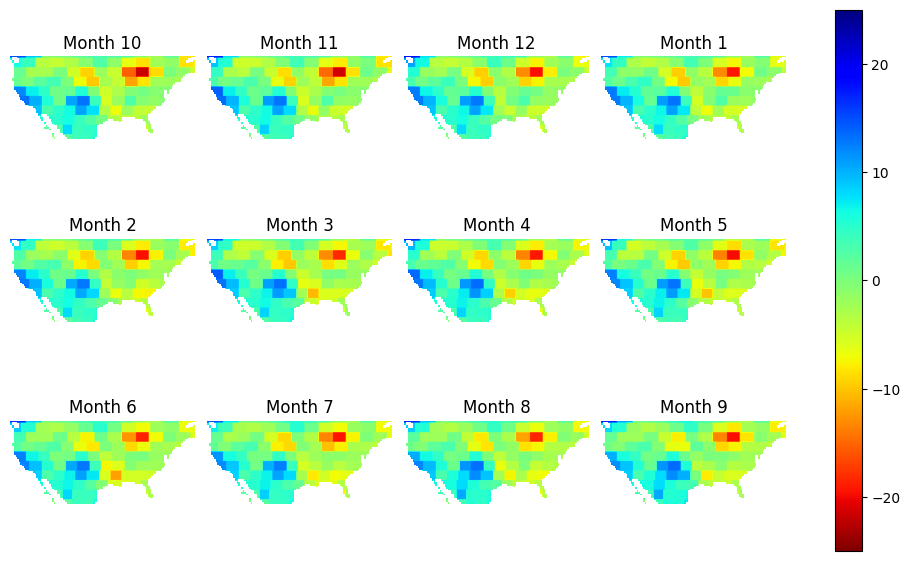

In [14]:
#example of a plot

pc1_months = month_split(pc1 * np.sqrt(eigenvalues[0]))

plot = months_plot(pc1_months)

(1428, 12)

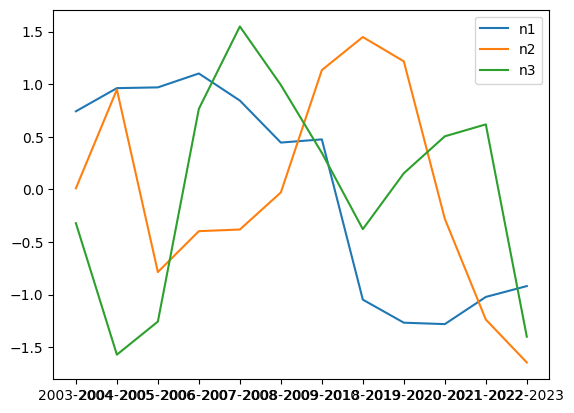

In [15]:
#creating the A matrix for the least square method for the 12 full years
A = np.copy(eigenvectors)

#multiplying corresponding eigenvectors w/ eigenvalues
for i in range(number_of_singular_values):
    A[:,i] = eigenvectors[:,i] * np.sqrt(eigenvalues[i])
    
#b for the 12 year matrix should just be u_a matrix
b = u_a.copy()

#least square method in numpy
n_matrix, residuals, rank, s = np.linalg.lstsq(A,b, rcond=None)

#corresponding years for the matrix
vals = ["2003-2004", "2004-2005", "2005-2006", "2006-2007", 
         "2007-2008", "2008-2009", "2009-2010", "2018-2019", 
         "2019-2020", "2020-2021", "2021-2022", "2022-2023"]

#plotting the n_matrix values as the change through time
plt.figure()
plt.plot(vals, n_matrix[0,:], label = "n1")
plt.plot(vals, n_matrix[1,:], label = "n2")
plt.plot(vals, n_matrix[2,:], label = "n3")
plt.legend()

n_matrix.shape

In [16]:
#storing the approximations of the 12 years in this list
approx_12_years = []

for i in range(12):
    approx_for_year = u_approx(n_matrix[:,i], eigenvalues, eigenvectors, u_bar)
    approx_12_years.append(approx_for_year)

0.07586550175531086


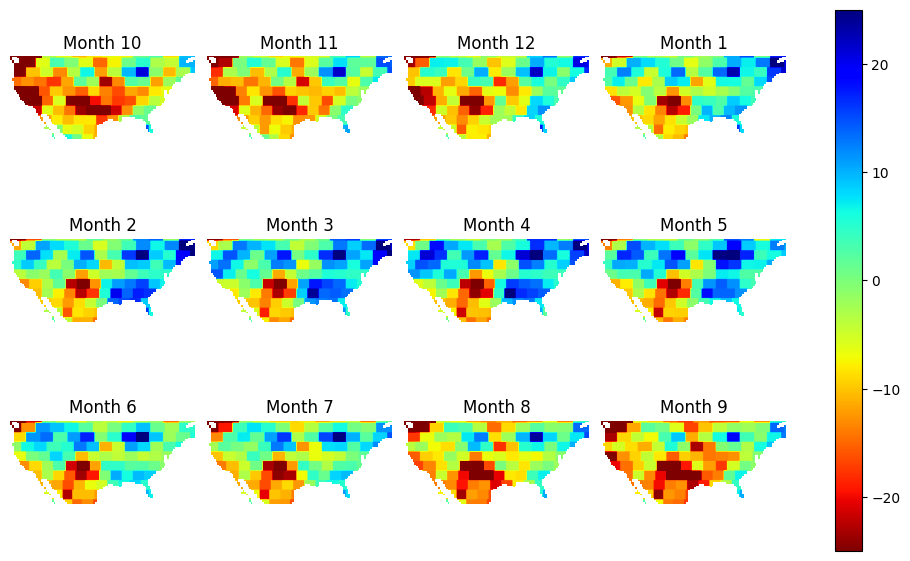

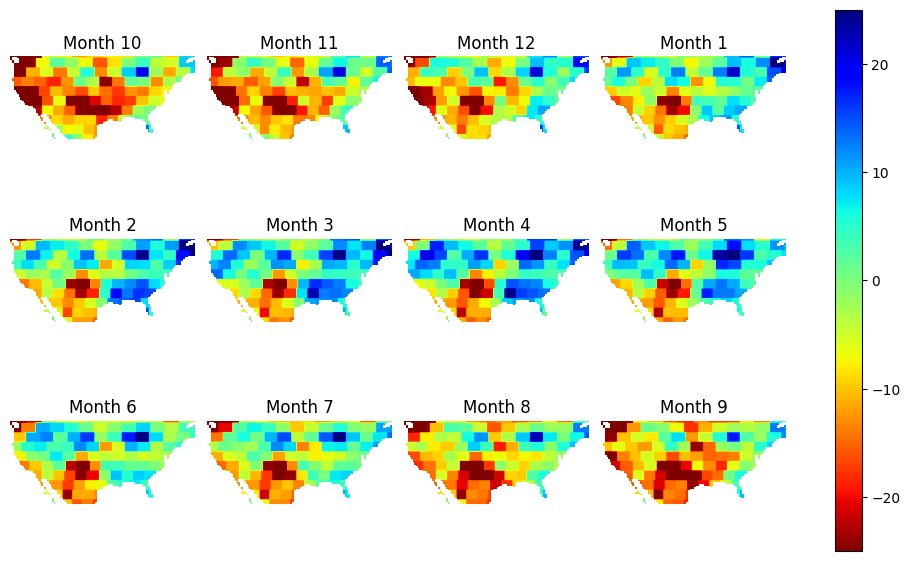

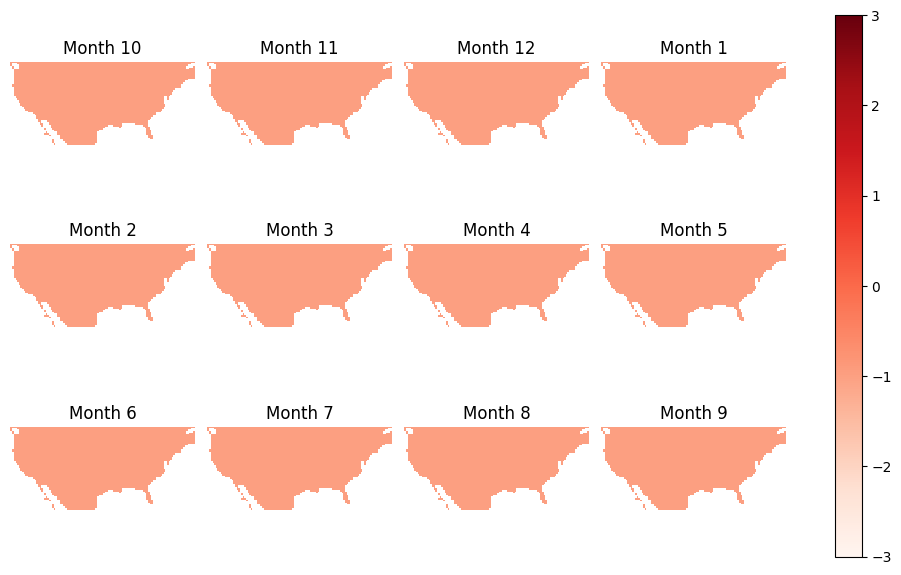

In [17]:
#value for the specific year i(index) want to compare
x = 11

plot = months_plot(month_split(approx_12_years[x]))
plot2 = months_plot(month_split(matrix[:,x]))
plot3 = months_plot(month_split((matrix[:,x] - approx_12_years[x])), set_color = 'Reds', vmin = -3, vmax = 3)

#mean squared error
mse = np.linalg.norm((matrix[:,x] - approx_12_years[x]), 2)

#relative error
print(mse / np.linalg.norm(matrix[:,x]))

In [18]:
# Used these two functions for the years that had gaps in them

#function for calculating rel error between year/realization vectors
def calculating_rel_error(act, gen, months):
    #act is the real year vector 
    #gen is the generated year vector
    #months is the list of available months to that year_vector
    
    #if there gaps in the act vector (i.e. not a full 12 moths)
    if len(months) != 12:
        reduced_gen = np.ones(act.shape[0])
        for i in range(len(months)):
            idx = (months[i] + 2) % 12

            reduced_gen[i*119:(i+1) * 119] = gen[idx*119:(idx+1) * 119]
            
        abs_error = np.linalg.norm(act - reduced_gen)

        return abs_error / np.linalg.norm(act)
    else:
        abs_error = np.linalg.norm(act - gen)

        return abs_error / np.linalg.norm(act)

# computing n coeffecients for years with month gaps in them
def computing_n(months, array, eigenvectors, eigenvalues, u_bar = u_bar):
    #months is the list of available months to that year_vector
    #array is the 1-D array for that year vector
    #u_bar is the mean of the 12 year matrix
    
    #not a full 12 months available
    if len(months) != 12:
        
        #reduce column size of eigenvectors and u bar to be that of the array size
        reduced_eigv = np.ones((array.shape[0], eigenvectors.shape[1]))
        reduced_u_bar = np.ones(array.shape[0])
        
        #loop to choose only the months that are represented in that year vector
        for i in range(len(months)):
            idx = (months[i] + 2) % 12

            reduced_eigv[i*119:(i+1) * 119,:] = eigenvectors[idx*119:(idx+1) * 119,:]
            reduced_u_bar[i*119:(i+1) * 119] = u_bar[idx*119:(idx+1) * 119]

        #same setup for matrix A as before except using the reduced matrixes and arrays
        A = np.copy(reduced_eigv)
        for i in range(len(eigenvalues)):
            A[:,i] = A[:,i] * np.sqrt(eigenvalues[i])
        b = array - reduced_u_bar

        n, residuals, rank, s = np.linalg.lstsq(A,b, rcond=None)

        return n
    else:
        # print("full matrix")
        A = np.copy(eigenvectors)
        for i in range(len(eigenvalues)):
            A[:,i] = A[:,i] * np.sqrt(eigenvalues[i])
        b = array - u_bar

        n, residuals, rank, s = np.linalg.lstsq(A,b, rcond=None)
        
        return n

12


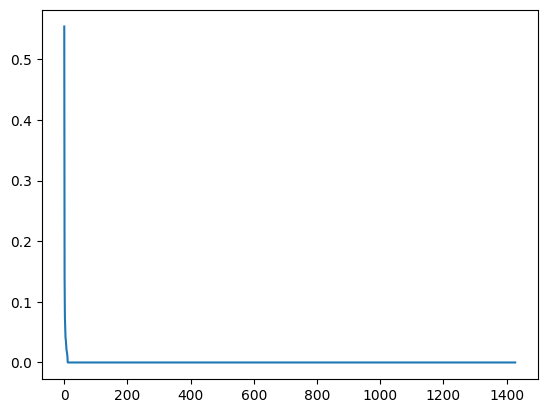

In [19]:
#plot of the percentage each eigenvalue / total sum of eigenvalues
total = np.sum(eigenvalues)

plt.plot(range(eigenvalues.shape[0]), eigenvalues / total)

per = 1
count = 0
while per > 10e-10:
    per = eigenvalues[count] / total
    count += 1
    
print(count)

In [20]:
#This is the dataloader that loads the months available and the year vector into a list called list_of_moths_available_every_year
#tuple = ((list) months, (numpy array) year_array)
month_start = 10


current_year = 2001

current_month = 10

list_of_months_available_every_year = []

i = 0

month = ds["time"].dt.month.values
year = ds["time"].dt.year.values

while i < 230:
    year_array = np.zeros(1)
    months = []
    
    for j in tqdm(range(12)):
        if (month[i] == month[i - 1] and year[i] == year[i-1]):
            # print("skip")
            i += 1
            continue
        #this is the data at time(starts with october)
        data_at_time = lwe.isel(time = i)
        # print(time + j + step_size * i)
        
        #this just masks the data based on where land_mask equals 1
        masked_data = data_at_time.where(lm == 1, drop = False)

        #this then slices the data for just the USA region
        usa_data = masked_data.sel(lat=slice(24, 50), lon=slice(-125+360, -67+360))
        
        usa_matrix = usa_data.values
        
        # Get unique elements and the indices of their first occurrence
        unique_elements, indices = np.unique(usa_matrix, return_index=True)

        # Sort the indices to get the unique elements in the order they first appear
        sorted_indices = np.argsort(indices)
        ordered_unique_elements = unique_elements[sorted_indices]
        
        ordered_unique_elements = ordered_unique_elements[1:]
        
        #concatenate the vector
        year_array = np.concatenate((year_array, ordered_unique_elements))
        months.append(month[i])
        # print(month[i])
        # print(i)
        i += 1

        if i == 230 or (month[i] >= month_start and year[i] == current_year + 1) or year[i] > current_year + 1:
            current_year += 1
            break
    list_of_months_available_every_year.append((months, year_array[1:]))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [21]:
#example of the months available to a specific year and array shape
c = 16
print(2001 + c)

months, array = list_of_months_available_every_year[c]
print(months)
print(array.shape)

2017
[6, 7]
(238,)


In [22]:
#getting the n vector for a specific year
n1 = computing_n(months, array, eigenvectors[:,:11], eigenvalues[:11])
print(n1.shape)

#approximation of the year_vector filled in
approx = u_approx(n1, eigenvalues, eigenvectors, u_bar)

#relative error between the months that were generated vs. actual
rel_error = calculating_rel_error(array, approx, months)
print(rel_error)

(11,)
0.3122106087458864


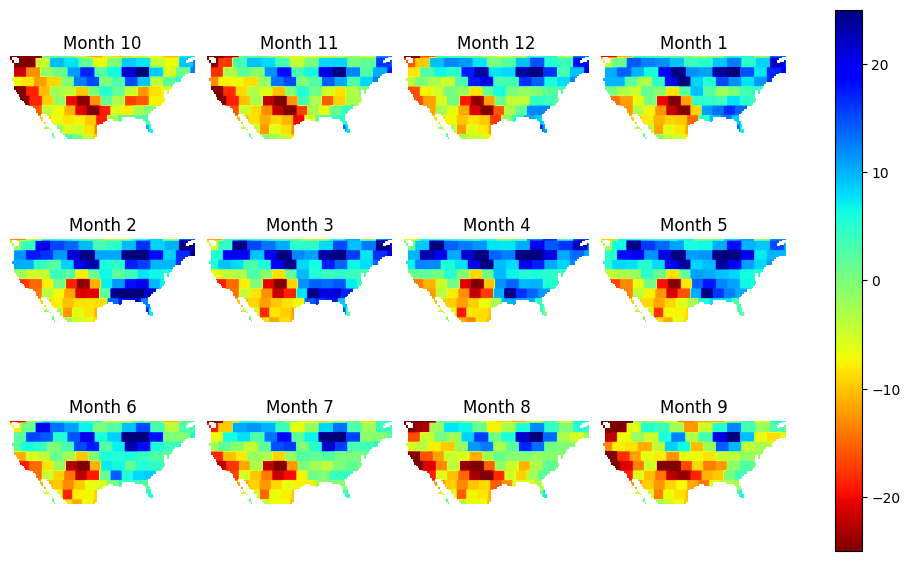

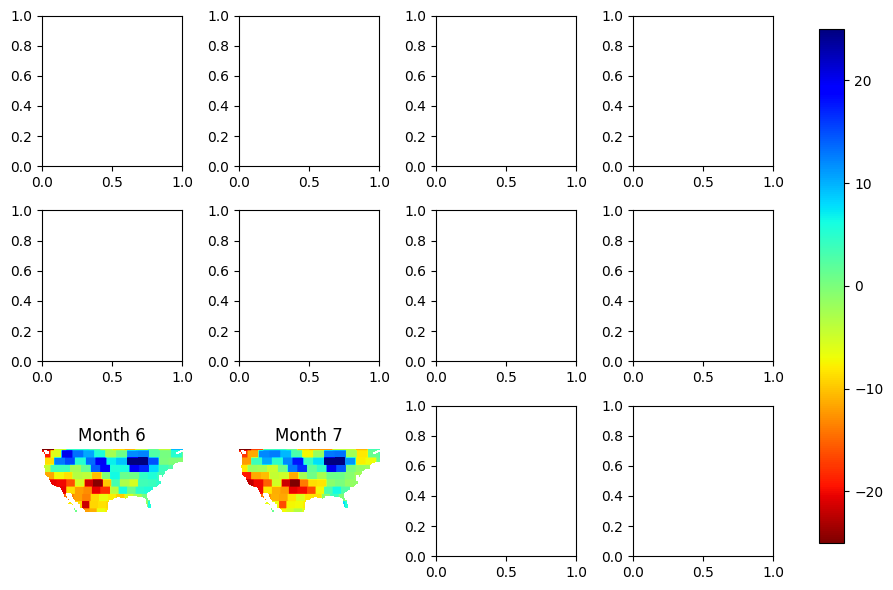

In [24]:
#plots
plot = months_plot(month_split(approx))
plot2 = months_plot(month_split(array, len(months)), list_m = months)

In [25]:
n_matrix = np.zeros((13,23))
for i in range(23):
    
    months, array = list_of_months_available_every_year[i]
    n = computing_n(months, array, eigenvectors[:,:13], eigenvalues[:13])
    n_matrix[:,i] = n

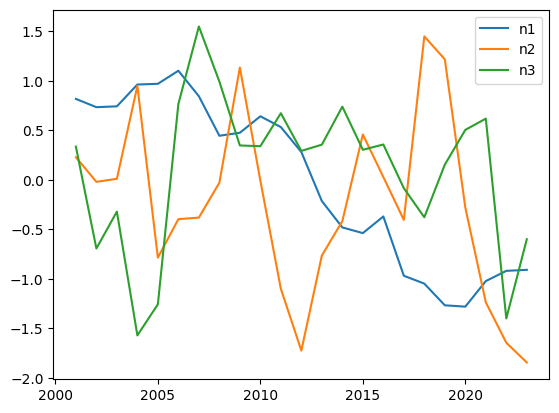

In [26]:
vals = np.arange(23)+2001

plt.figure()
plt.plot(vals, n_matrix[0,:], label = "n1")
plt.plot(vals, n_matrix[1,:], label = "n2")
plt.plot(vals, n_matrix[2,:], label = "n3")
# plt.plot(vals, n_matrix[3,:], label = "n4")
plt.legend()

SyntaxError: invalid syntax (2830201818.py, line 1)